In [1]:
load_ext cython

In [3]:
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.io import loadmat
import sys
from math import exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

#parameters
time_len = 1000
activations_len = 5
gaussian_variance = 1000

#datasets
activations = None
gaussian_array = None
covariances = None

def correlation_calculation_alternative(activations):

    # #cython variable declaration
    # cdef int time_len, activations_len, subj_num, timepoint, gaussian_variance, subject, i, j, index
    # cdef double val
    # cdef np.ndarray[double, ndim=2] covariances_vector, coefficient, sigma, activations_temp
    # cdef np.ndarray[double, ndim=3] covariances, covariance_fragments
    # cdef np.ndarray gaussian_array, sigma_temp

    #assign initial parameters
    # gaussian_variance = 1000
    # activations_len, time_len= activations.shape[0], activations.shape[1]
    covariances = covariance_fragments = np.zeros([time_len,activations_len,activations_len])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])
    gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])

    for timepoint in range(time_len):
        coefficient = gaussian_array[(time_len-1-timepoint):(2*time_len-1-timepoint)]
#         print(np.argmax(coefficient))
        coefficient_tiled = np.tile(coefficient/np.sum(coefficient),[activations_len,1])
        normalized_activations = activations - np.tile(np.reshape(np.mean(np.multiply(coefficient_tiled,activations),1),[activations_len,1]),[1,time_len])
        sigma_temp  = np.sqrt(np.sum(np.multiply(coefficient_tiled, np.square(normalized_activations)),1))
#         print(coefficient.shape, normalized_activations.shape)
        index = 0
        for i in range(activations_len-1):
            for j in range(i+1, activations_len):
                covariances_vector[timepoint, index] = np.sum(np.multiply(np.multiply(coefficient, normalized_activations[i]), normalized_activations[j]))/float(time_len)
#                 /(sigma_temp[i]*sigma_temp[j])
                index+=1
    
    return covariances_vector

In [9]:
import numpy as np
from math import sqrt, pi, exp

#parameter initialization
filename = "../../data/BDM_DATA/synthetic_data_validation.npz"
time_len = 1000
activations_len = 5
feature_std = 0.1
gaussian_variance = 20
subject_num=5

#data matrices
feature_maps = np.zeros([time_len,activations_len,activations_len])
covariance, covariance1 = np.zeros([activations_len,activations_len]), np.zeros([activations_len,activations_len])
activations = np.zeros([time_len,time_len,activations_len])
final_activation = np.zeros([time_len,activations_len])
gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])
covariance, covariance1 = np.zeros([activations_len,activations_len]), np.zeros([activations_len,activations_len])

def simplified_activations_generation():
    global covariance, covariance1,final_activation
    feature_map = np.random.normal(0,feature_std,[activations_len,activations_len])
    covariance = np.dot(feature_map,feature_map.T)
    feature_map1 = np.random.normal(0,feature_std,[activations_len,activations_len])
    covariance1 = np.dot(feature_map1,feature_map1.T)
    final_activation[0,:] = initial_activation  = np.random.multivariate_normal(np.zeros(activations_len), covariance)
    for i in range(1, time_len):
#         final_activation[i, :] = np.random.multivariate_normal(final_activation[(i-1),:],covariance)
        final_activation[i,:]=
#         cov_temp = (1000-i)*covariance/1000.0+i*covariance1/1000.0
#         final_activation[i, :] = np.random.multivariate_normal(final_activation[(i-1),:],cov_temp)

#     for i in range(1, time_len/2):
#         final_activation[i,:] = np.random.multivariate_normal(final_activation[(i-1),:],covariance)
#     for i in range(time_len/2, time_len):
#         final_activation[i,:] = np.random.multivariate_normal(final_activation[(i-1),:],covariance1)
simplified_activations_generation()
activations = [final_activation for i in range(10)]
# +np.random.normal(0,0.01,[subject_num,time_len,activations_len])

In [ ]:
from timecorr import timecorr
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
final_activation = (final_activation-np.tile(np.mean(final_activation,0),[time_len,1]))/np.tile(np.std(final_activation,0),[time_len,1])
covariances_vector = timecorr(final_activation, var=100)
true_covariances_vector = squareform(covariance,checks=False)
true_covariances_vector1 = squareform(covariance1,checks=False)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
plt.plot(range(time_len),Y,'b-')
plt.plot(range(time_len),Y1,'r-')
plt.show()

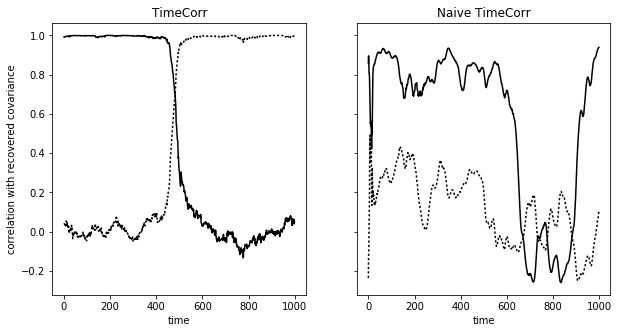

In [10]:
f, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))
covariances_vector = timecorr(final_activation, 1000, 3, "across")
true_covariances_vector = squareform(covariance,checks=False)
true_covariances_vector1 = squareform(covariance1,checks=False)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
ax1.plot(range(time_len),Y,'k-')
ax1.plot(range(time_len),Y1,'k:')
ax1.set_title('TimeCorr')
ax1.set_xlabel('time')
ax1.set_ylabel('correlation with recovered covariance')

covariances_vector = correlation_calculation_alternative(final_activation.T)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
ax2.plot(range(time_len),Y,'k-')
ax2.plot(range(time_len),Y1,'k:')
ax2.set_title('Naive TimeCorr')
ax2.set_xlabel('time')

plt.show()

(1000, 10)


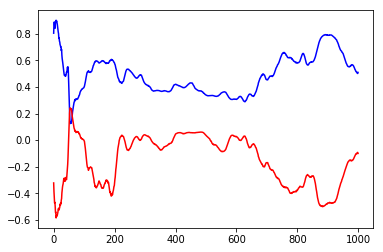

In [7]:
covariances_vector = correlation_calculation_alternative(final_activation.T)
print covariances_vector.shape
true_covariances_vector = squareform(covariance,checks=False)
true_covariances_vector1 = squareform(covariance1,checks=False)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
plt.plot(range(time_len),Y,'b-')
plt.plot(range(time_len),Y1,'r-')
plt.show()

In [4]:
import numpy as np
data = np.load("../data/synthetic_data_cross.npz")
activations = [data['arr_2'].T]

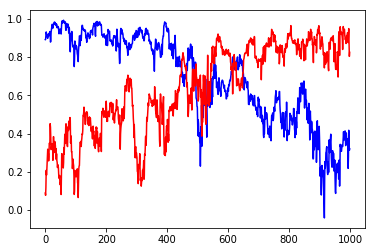

In [10]:
from timecorr import timecorr
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
data = np.load("../data/synthetic_data_cross.npz")
activations = data['arr_2']
true_covariances = data['arr_0']
true_covariances1 = data['arr_1']
activations_len, time_len = activations.shape
covariances_vector = timecorr([activations.T], int(100), int(3), "within")
true_covariances_vector = squareform(true_covariances,checks=False)
true_covariances_vector1 = squareform(true_covariances1,checks=False)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
plt.plot(range(time_len),Y,'b-')
plt.plot(range(time_len),Y1,'r-')
plt.show()

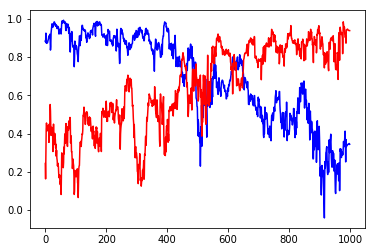

In [13]:
from timecorr import timecorr
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
data = np.load("../data/synthetic_data_cross.npz")
activations = data['arr_2']
true_covariances = data['arr_0']
true_covariances1 = data['arr_1']
activations_len, time_len = activations.shape
covariances_vector = timecorr([activations.T], int(100), int(25), "within")
true_covariances_vector = squareform(true_covariances,checks=False)
true_covariances_vector1 = squareform(true_covariances1,checks=False)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
plt.plot(range(time_len),Y,'b-')
plt.plot(range(time_len),Y1,'r-')
plt.show()

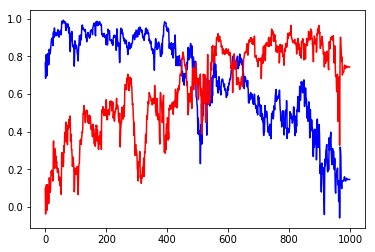

In [12]:
from timecorr import timecorr
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
data = np.load("../data/synthetic_data_cross.npz")
activations = data['arr_2']
true_covariances = data['arr_0']
true_covariances1 = data['arr_1']
activations_len, time_len = activations.shape
covariances_vector = timecorr([activations.T], int(100), int(51), "within")
true_covariances_vector = squareform(true_covariances,checks=False)
true_covariances_vector1 = squareform(true_covariances1,checks=False)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
plt.plot(range(time_len),Y,'b-')
plt.plot(range(time_len),Y1,'r-')
plt.show()

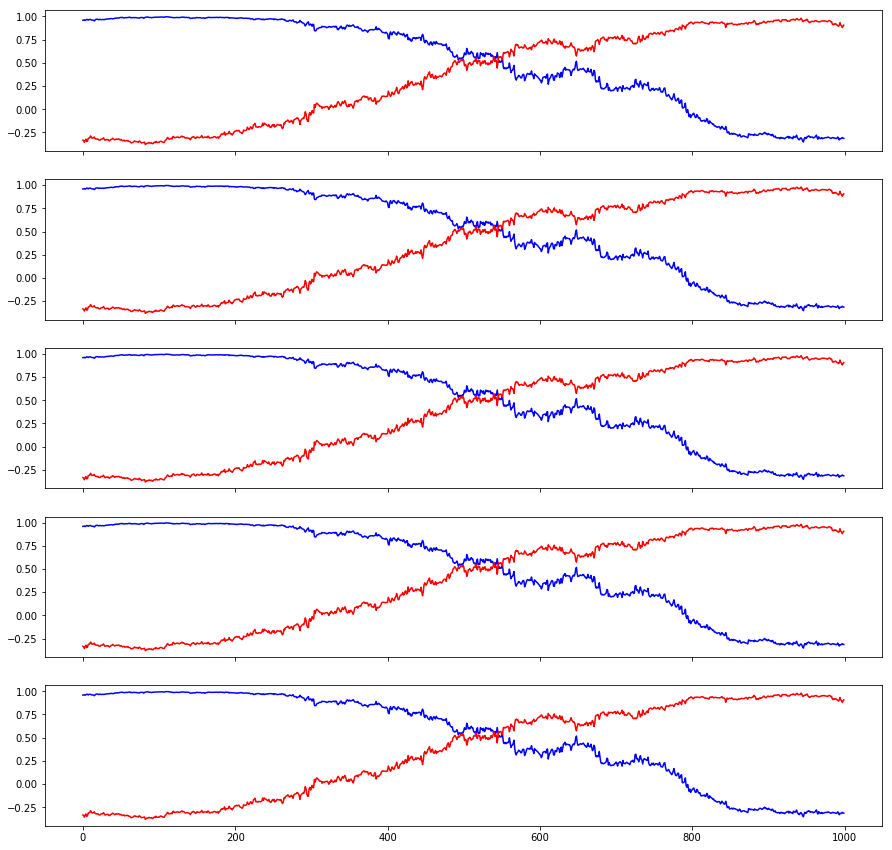

In [15]:
covariances_vectors = timecorr(activations, 1000, 3, "within")
f, axarr = plt.subplots(subject_num, sharex=True, figsize=(15,15))
for subj, covariances_vector in enumerate(covariances_vectors):
    true_covariances_vector = squareform(covariance,checks=False)
    true_covariances_vector1 = squareform(covariance1,checks=False)
    Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
    Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
    axarr[subj].plot(range(time_len),Y,'b-')
    axarr[subj].plot(range(time_len),Y1,'r-')
plt.show()